<h1>The XINOMAVRO Project - Applied Data Science Capstone Project Notebook</h1>

<h3>This notebook contains the capstone project of "Applied Data Science Capstone" course of " Data Science Professional Certitificate" Program</h3>

## Import all necessary labraries

In [2]:
#Import basic Pandas and Numpy libraries
import pandas as pd
import numpy as np

#Import folium library for map design
!pip install folium
import folium

#Import json, requests to handle the Foursquare API response
import json
import requests

#Import from matplotlib, plotting related libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#Import plandasql library, an auxiliary library in order to use SQL commands directly to Pandas Dataframes
!pip install -U pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

#Import Kmeans from sklearn
from sklearn.cluster import KMeans


Requirement already up-to-date: pandasql in c:\users\ikape\anaconda3\lib\site-packages (0.7.3)


## Load Greek Cities Population and Location Data

In [177]:
greek_cities_df=pd.read_html('http://www.tageo.com/index-e-gr-cities-GR.htm')[16]

#Fix the header row
greek_cities_df.rename(columns=greek_cities_df.iloc[0], inplace = True)
greek_cities_df.drop([0], inplace = True)

#Drop unnecessary column Rank
greek_cities_df.drop(columns=['Rank'], inplace = True)

#Rename and convert all the other columns
greek_cities_df.rename(columns={'Latitude (DD)':'Latitude','Longitude (DD)':'Longitude','Population (2000)':'Population'}, inplace=True)
greek_cities_df['Population']=greek_cities_df['Population'].astype(str).astype(int)

#Rename Iraklion in Crete with population 133800, to be distinct from Iraklio Attica with population 47000
greek_cities_df.loc[greek_cities_df.Population==133800, 'City'] = 'Iraklion_Crete'

greek_cities_df.head()

,City,Population,Latitude,Longitude
1,Athinai,762100,37.980,23.730
2,Thessaloniki,372100,40.640,22.940
3,Piraieus,179600,37.960,23.640
4,Patrai,164000,38.240,21.730
5,Peristerion,141000,38.020,23.700


### Show Greek Cities on the map

#### Create size and color columns to use in the map

In [785]:
greek_cities_map_df=greek_cities_df.copy()

#Create size column based on 3 bins
greek_cities_map_df['city_size'] = pd.qcut(greek_cities_map_df['Population'], 3, 
                              labels=[3,  5, 7])

#Create color column based on 3 bins
greek_cities_map_df['marker_color'] =  pd.qcut(greek_cities_map_df['Population'], 3, 
                              labels=['blue', 'green', 'red'])

greek_cities_map_df.head()

,City,Population,Latitude,Longitude,city_size,marker_color
1,Athinai,762100,37.980,23.730,7,red
2,Thessaloniki,372100,40.640,22.940,7,red
3,Piraieus,179600,37.960,23.640,7,red
4,Patrai,164000,38.240,21.730,7,red
5,Peristerion,141000,38.020,23.700,7,red


#### Check Cities on the map based on their population

In [786]:
# create map
map_cities =folium.Map(location=[38.2749497, 23.8102717],height='100%', zoom_start=7, language='en')


# add markers to the map
for lat, lon, poi,m_color,sz,pop in zip(greek_cities_map_df['Latitude'], greek_cities_map_df['Longitude'], greek_cities_map_df['City'],\
                                        greek_cities_map_df['marker_color'],greek_cities_map_df['city_size'],greek_cities_map_df['Population']):
    label = folium.Popup(str(poi), parse_html=True)
    label = folium.Popup(str(poi) + ' Population ' + str(pop), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=[sz],
        popup=label,
        fill=True,
        fill_opacity=0.7, color=[m_color]).add_to(map_cities)
 
map_cities

## Get venues info from Foursquare

### Define Foursqare Credentials

In [6]:
CLIENT_ID = 'ZWLQVDCUED4OJT423RUMHPFZGZWFOUDMA4M1DDFECN1OAA1C' 
CLIENT_SECRET = 'IAYM1Y3KF5OMIESASVZH02ZHBM1XSESUMM4BEMG23TI0KLGM' 
ACCESS_TOKEN = 'TRLXKRJWEAECJ51UAZFSJW5FK4ENUEYNQYALHEZ5331CTRPO' 
VERSION = '20201231' 
LIMIT = 500

### Get Wine Bar Venues for each City

#### Create function to get Venues of specific category around each city location

In [8]:
def getNearbyVenues(names,population, latitudes, longitudes, radius=1500, category='4bf58dd8d48988d123941735'):
    
    venues_list=[]
    for name,population, lat, lng in zip(names,population, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            population,
            lat, 
            lng, 
            v['id'], 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['location']['distance'], 
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                             'Population',
                  'City_Latitude', 
                  'City_Longitude', 
                  'Venue_Id',
                  'Venue_Name', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Distance',
                  'Venue_Category']
    
    return(nearby_venues)


#### Get Wine Bar Venues

In [109]:
#Wine Bar Category ID = 4bf58dd8d48988d123941735
cities_winebars_raw_df= getNearbyVenues(names=greek_cities_df['City'],
                                  population=greek_cities_df['Population'],
                                   latitudes=greek_cities_df['Latitude'],
                                   longitudes=greek_cities_df['Longitude'],
                                  category='4bf58dd8d48988d123941735')

In [142]:
cities_winebars_raw_df.shape

(462, 10)

##### Check for venues assigned in more than on city

In [143]:
pd.DataFrame(pysqldf("select venue_id,venue_name, count(*) from cities_winebars_raw_df group by venue_id,venue_name having count(*)>1")).head()


,Venue_Id,Venue_Name,count(*)
0,4adcdadef964a520f15721e3,Peacock Roof Garden Restaurant,2
1,4c24c439a852c928549de36c,Coq Au Zen,2
2,4d41d00789c3a143abd2f183,Oinoscent,2
3,4d598cb524466ea852ac789f,Lithinoi (Ληθηνόη),2
4,4d63e70b1a83f04d209d782b,Το Δώμα,2


##### Duplicate Example

In [144]:
pd.DataFrame(pysqldf("select * from cities_winebars_raw_df where venue_id='4d41d00789c3a143abd2f183'")).head()

,City,Population,City_Latitude,City_Longitude,Venue_Id,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Distance,Venue_Category
0,Athinai,762100,37.980,23.730,4d41d00789c3a143abd2f183,Oinoscent,37.974037,23.732125,689,Wine Bar
1,Viron,62500,37.970,23.750,4d41d00789c3a143abd2f183,Oinoscent,37.974037,23.732125,1631,Wine Bar


##### Remove Duplicate Venues

In [145]:
#Remove duplicate Venues by keeping only the assignment with the min distance city
cities_winebars_df=pysqldf(" select * from (select * , row_number() over (partition by venue_id order by Venue_Distance) rn from cities_winebars_raw_df) ff where rn=1")
cities_winebars_df.drop(columns=['rn'], inplace = True)

In [146]:
cities_winebars_df.shape

(388, 10)

#### Get an idea of how many wine bars each city has

In [119]:
pysqldf("select count(*), city from cities_winebars_df group by city")

,count(*),City
0,7,Agrinion
1,1,Aigaleo
2,2,Akharnai
3,6,Alexandroupoli
4,3,Amarousion
5,1,Ambelokipoi
6,3,Aryiroupoli
7,46,Athinai
8,1,Ayia paraskevi
9,5,Ayios dimitrios


#### Get Bistrot Venues

In [115]:
#Bistro Category ID = 52e81612bcbc57f1066b79f1
cities_bistrot_raw_df= getNearbyVenues(names=greek_cities_df['City'],
                                  population=greek_cities_df['Population'],
                                   latitudes=greek_cities_df['Latitude'],
                                   longitudes=greek_cities_df['Longitude'],
                                  category='52e81612bcbc57f1066b79f1'  
                                  )

In [148]:
cities_bistrot_raw_df.shape

(240, 10)

##### Remove Duplicates and Venues already marked as wine bars

In [117]:
#Keep only bistro that are not in the wine bar list and if are assigned in more thatn one city, keep the min distance city
cities_bistrot_df=pysqldf(" select * from (select * , row_number() over (partition by venue_id order by Venue_Distance) rn from cities_bistrot_raw_df) ff where rn=1 and venue_id not in (select venue_id from cities_winebars_df)")

In [147]:
cities_bistrot_df.shape

(193, 11)

#### Get an idea of how many Bistro each city has

In [126]:
pysqldf("select count(*), city from cities_bistrot_df group by city")

,count(*),City
0,4,Agrinion
1,1,Aigaleo
2,4,Alexandroupoli
3,3,Amarousion
4,2,Ambelokipoi
5,38,Athinai
6,5,Ayia paraskevi
7,1,Drama
8,3,Euosmon
9,2,Glifada


### Get Price, Likes and Rating Details for each Venue

In [26]:
#cities_winebars_df[cities_winebars_df.Venue_Id=='546d2592498e207ac48c048d']
#Cold restart
#tmp=pd.read_csv(('c:\Temp\winebars_details.csv'))
#winebars_raw_df=tmp.drop(columns='Unnamed: 0')
#winebars_raw_df.shape

(389, 5)

In [132]:
venues_list=[]

for venueid in to_load['Venue_Id']:

    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&oauth_token={}&v={}'.format(
            venueid,
            CLIENT_ID, 
            CLIENT_SECRET,
            ACCESS_TOKEN,
            VERSION)

    # make the GET request
    results = requests.get(url).json()["response"]['venue']
 
    #handle missing tags in jsaon: rating and price
    if 'rating' not in results:
        results['rating']=-1
    
    if 'price' not in results:
        results['price']={'tier':-1}
    
    #Put API response in venues_list
    venues_list.append([
    venueid,
    results['name'], 
    results['price']['tier'] ,
    results['likes']['count'],  
    results['rating'] ]) 
 
#Insert results into a dataframe
winebars_raw_df= pd.DataFrame (venues_list,columns = ['Venue_ID', 'Venue_Name',   'Price', 'Likes', 'Rating'])

#### Explore Wine Bar Details

##### Check for missing values

In [297]:
pd.DataFrame(pysqldf("select sum(case when price=-1 then 1 else 0 end) missing_price, sum(case when rating=-1 then 1 else 0 end) missing_rating, sum(case when likes=0 then 1 else 0 end ) missing_likes from winebars_raw_df "))

,missing_price,missing_rating,missing_likes
0,14,231,109


##### Check box plot for likes to better understand the distribution of values

<AxesSubplot:ylabel='Likes'>

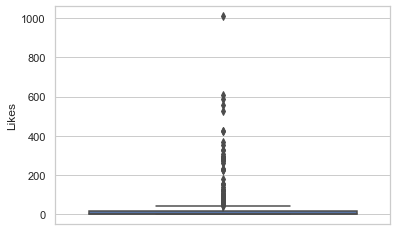

In [168]:
import seaborn as sns
sns.set_theme(style="whitegrid")

sns.boxplot( y="Likes", data=winebars_raw_df)


#### Merge the two Wine bars related DataFrames

In [152]:
merge_winebars_df=pysqldf("select t1.*, t2.price,t2.Likes,t2.Rating from cities_winebars_df t1  inner join winebars_raw_df t2 on t1.venue_id=t2.venue_id ")
merge_winebars_df.head()

,City,Population,City_Latitude,City_Longitude,Venue_Id,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Distance,Venue_Category,Price,Likes,Rating
0,Athinai,762100,37.980,23.730,4adcdadef964a520f15721e3,Peacock Roof Garden Restaurant,37.967037,23.729066,1445,Wine Bar,2,4,6.7
1,Nea smirni,75600,37.950,23.720,4adcdadff964a520215821e3,CAFÉ & BISTROT VIENNA,37.959631,23.721627,1081,Café,1,15,7.5
2,Athinai,762100,37.980,23.730,4adcdadff964a520275821e3,The Cellar,37.975834,23.733130,538,Wine Bar,2,0,-1.0
3,Volos,84300,39.370,22.950,4b5b2f7ff964a52087e928e3,Gala 1985,39.360207,22.950074,1090,Café,2,59,7.7
4,Athinai,762100,37.980,23.730,4b684c8bf964a52057702be3,Chocolat Royal,37.974199,23.719969,1091,Restaurant,2,355,6.9


#### Deal with missing values

Handle missing values by calculating the averages per city to fill the gaps for price and rating

In [313]:
#Make all the missing values marked with -1 to NaN
cities_winebars_df=merge_winebars_df.replace(-1,np.NaN)
cities_winebars_df=cities_winebars_df.replace(0,np.NaN)

cities_winebars_df=pysqldf("select t1.*, avg(price) over (partition by city) avg_price_city,avg(rating) over (partition by city) avg_rating_city,avg(likes) over (partition by city) avg_likes_city from cities_winebars_df t1")

cities_winebars_df.Price.fillna(round(cities_winebars_df.avg_price_city), inplace=True)
cities_winebars_df.Rating.fillna(round(cities_winebars_df.avg_rating_city,1), inplace=True)

cities_winebars_df.head(20)

,City,Population,City_Latitude,City_Longitude,Venue_Id,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Distance,Venue_Category,Price,Likes,Rating,avg_price_city,avg_rating_city,avg_likes_city
0,Agrinion,43300,38.620,21.410,4ef7bcff9a52c9084162333c,Αποστακτήριο,38.626668,21.410383,743,Wine Bar,2.0,18.0,6.2,2.0,6.900000,9.200000
1,Agrinion,43300,38.620,21.410,4f888989e4b055d22f24f79d,Sto Mpriki,38.624083,21.410174,454,Wine Bar,2.0,NaN,6.9,2.0,6.900000,9.200000
2,Agrinion,43300,38.620,21.410,4fd257ace4b03e7cee49b10a,Kartoutso,38.625623,21.401804,948,Wine Bar,2.0,6.0,6.4,2.0,6.900000,9.200000
3,Agrinion,43300,38.620,21.410,50dcb65ee4b0ed9af9907c87,Σείριος,38.624446,21.409950,494,Wine Bar,2.0,2.0,6.9,2.0,6.900000,9.200000
4,Agrinion,43300,38.620,21.410,517ad5bfe4b0b09096e99917,Στο Μπρικι,38.624527,21.409966,503,Wine Bar,2.0,NaN,6.9,2.0,6.900000,9.200000
5,Agrinion,43300,38.620,21.410,5186d965498e1a1f75f686a2,mistral,38.625008,21.408688,569,Wine Bar,2.0,2.0,6.9,2.0,6.900000,9.200000
6,Agrinion,43300,38.620,21.410,549d4b4e498e81619d3b9199,C-Bar,38.623692,21.409592,412,Wine Bar,2.0,18.0,8.1,2.0,6.900000,9.200000
7,Aigaleo,75700,37.980,23.680,501db95ee4b099ff77415dae,Skalakia,37.970985,23.696356,1751,Wine Bar,2.0,NaN,NaN,2.0,NaN,NaN
8,Akharnai,77000,38.080,23.730,4dd6c03cd22d38ef42d76956,Μπακαλόγατος,38.082480,23.728551,303,Wine Bar,2.0,3.0,NaN,2.0,NaN,3.000000
9,Akharnai,77000,38.080,23.730,4efe5b71490182a1a64bfef2,tuflomuga,38.072133,23.719943,1242,Wine Bar,2.0,NaN,NaN,2.0,NaN,3.000000


For the cities that didnt have values the values for price and rating are still missing. Fill the gaps with the total average. 
<p>For missing Likes value fill the gaps with the median of all Likes values

In [314]:
#Calculate the average value for price and rating
mean_price=cities_winebars_df['Price'].mean()
mean_rating=cities_winebars_df['Rating'].mean()
median_likes=cities_winebars_df['Likes'].median()

#Replace missing values with the average for each variable
cities_winebars_df['Price']=cities_winebars_df['Price'].replace(np.NaN,round(mean_price))
cities_winebars_df['Rating']=cities_winebars_df['Rating'].replace(np.NaN,round(mean_rating,1))
cities_winebars_df['Likes']=cities_winebars_df['Likes'].replace(np.NaN,median_likes)

cities_winebars_df.head(10)

,City,Population,City_Latitude,City_Longitude,Venue_Id,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Distance,Venue_Category,Price,Likes,Rating,avg_price_city,avg_rating_city,avg_likes_city
0,Agrinion,43300,38.620,21.410,4ef7bcff9a52c9084162333c,Αποστακτήριο,38.626668,21.410383,743,Wine Bar,2.0,18.0,6.2,2.0,6.9,9.2
1,Agrinion,43300,38.620,21.410,4f888989e4b055d22f24f79d,Sto Mpriki,38.624083,21.410174,454,Wine Bar,2.0,7.0,6.9,2.0,6.9,9.2
2,Agrinion,43300,38.620,21.410,4fd257ace4b03e7cee49b10a,Kartoutso,38.625623,21.401804,948,Wine Bar,2.0,6.0,6.4,2.0,6.9,9.2
3,Agrinion,43300,38.620,21.410,50dcb65ee4b0ed9af9907c87,Σείριος,38.624446,21.409950,494,Wine Bar,2.0,2.0,6.9,2.0,6.9,9.2
4,Agrinion,43300,38.620,21.410,517ad5bfe4b0b09096e99917,Στο Μπρικι,38.624527,21.409966,503,Wine Bar,2.0,7.0,6.9,2.0,6.9,9.2
5,Agrinion,43300,38.620,21.410,5186d965498e1a1f75f686a2,mistral,38.625008,21.408688,569,Wine Bar,2.0,2.0,6.9,2.0,6.9,9.2
6,Agrinion,43300,38.620,21.410,549d4b4e498e81619d3b9199,C-Bar,38.623692,21.409592,412,Wine Bar,2.0,18.0,8.1,2.0,6.9,9.2
7,Aigaleo,75700,37.980,23.680,501db95ee4b099ff77415dae,Skalakia,37.970985,23.696356,1751,Wine Bar,2.0,7.0,7.5,2.0,NaN,NaN
8,Akharnai,77000,38.080,23.730,4dd6c03cd22d38ef42d76956,Μπακαλόγατος,38.082480,23.728551,303,Wine Bar,2.0,3.0,7.5,2.0,NaN,3.0
9,Akharnai,77000,38.080,23.730,4efe5b71490182a1a64bfef2,tuflomuga,38.072133,23.719943,1242,Wine Bar,2.0,7.0,7.5,2.0,NaN,3.0


#### Wine Bars Metrics Values Distribution

##### Bar Chart for Price Distribution

<AxesSubplot:title={'center':'Price Distribution'}>

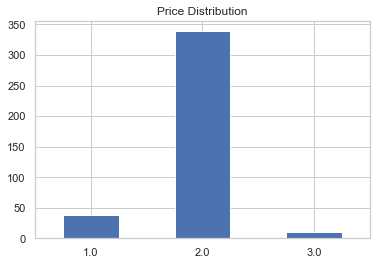

In [308]:
cities_winebars_df['Price'].value_counts().sort_index().plot.bar( x='Price', rot=0, title='Price Distribution')

##### Bar Chart for Likes Distribution after creating 4 bins for Likes values

<AxesSubplot:title={'center':'Likes Distribution (4 bins)'}>

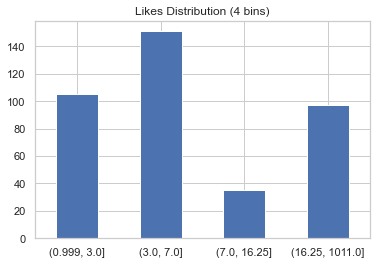

In [788]:
plot_likes=cities_winebars_df.copy()
plot_likes['like_group']=pd.qcut(plot_likes['Likes'], q=4)
plot_likes['like_group'].value_counts().sort_index().plot.bar( x='like_group', rot=0,title='Likes Distribution (4 bins)')

##### Box Plot for Rating Distribution

Text(0.5, 1.0, 'Rating Distribution')

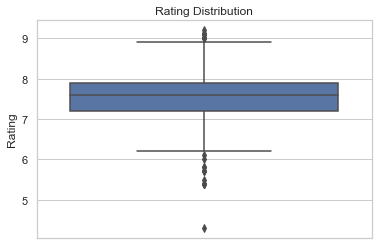

In [288]:
sns.boxplot( y="Rating", data=cities_winebars_df).set_title('Rating Distribution')

### Gather Wine bars data and Bistrot data per City

In [350]:
cities_bars_df=pysqldf("select t1.*, coalesce(t2.winebars,0) wine,coalesce(bistro,0) bistro,\
coalesce(avg_winebar_price,0) avg_winebar_price, coalesce(avg_winebar_likes,0) avg_winebar_likes,coalesce(avg_winebar_rating,0) avg_winebar_rating \
from greek_cities_df t1 left outer join (select  city, count(*) winebars, avg(price) avg_winebar_price, avg(likes) avg_winebar_likes,avg(rating) avg_winebar_rating from cities_winebars_df group by city) t2 on t1.city=t2.city \
left outer join (select  city,count(*) bistro from  cities_bistrot_df group by city) t4 on t1.city=t4.city ")

print ('Shape of cities_bars_df dataframe: '+ str(cities_bars_df.shape))
cities_bars_df.head()

Shape of cities_bars_df dataframe: (60, 9)


,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
0,Athinai,762100,37.980,23.730,46,38,2.000000,132.413043,7.695652
1,Thessaloniki,372100,40.640,22.940,46,16,1.869565,41.500000,7.602174
2,Piraieus,179600,37.960,23.640,4,2,2.000000,26.500000,9.100000
3,Patrai,164000,38.240,21.730,13,7,2.076923,26.384615,7.500000
4,Peristerion,141000,38.020,23.700,2,2,2.000000,5.500000,7.800000


#### Cities without WineBars

In [183]:
cities_bars_df[cities_bars_df.wine==0]

,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
13,Keratsinion,77800,37.960,23.620,0,0,0.0,0.0,0.0
21,Koridallos,69000,37.990,23.650,0,1,0.0,0.0,0.0
50,Stauroupolis,42600,40.670,22.930,0,0,0.0,0.0,0.0
53,Polikhni,37000,40.660,22.950,0,0,0.0,0.0,0.0
56,Ayioi anaryiroi,33700,38.020,23.720,0,0,0.0,0.0,0.0


#### Correlation Matrix for all variables                     

In [188]:
cities_bars_df.corr()

,Population,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
Population,1.000000,0.792194,0.794882,0.104709,0.474677,0.122423
wine,0.792194,1.000000,0.766216,0.205944,0.410255,0.219522
bistro,0.794882,0.766216,1.000000,0.149284,0.438063,0.148157
avg_winebar_price,0.104709,0.205944,0.149284,1.000000,0.256034,0.938278
avg_winebar_likes,0.474677,0.410255,0.438063,0.256034,1.000000,0.289187
avg_winebar_rating,0.122423,0.219522,0.148157,0.938278,0.289187,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

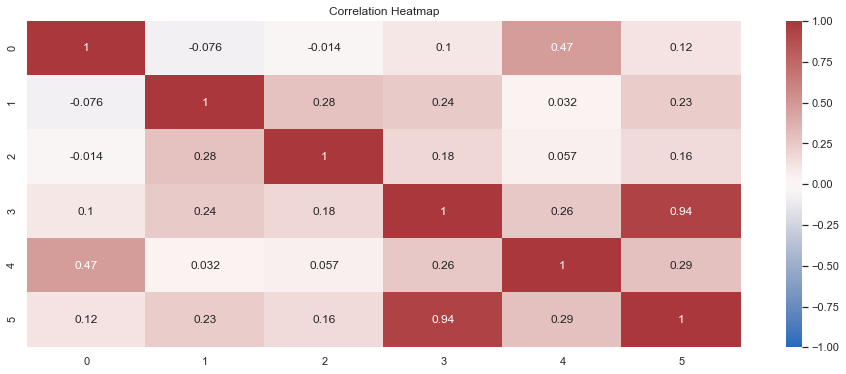

In [334]:
plt.figure(figsize=(16, 6))
sns.heatmap(cities_bars_df.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag').set_title('Correlation Heatmap')

#### Explore the correlation between Bistrot and Wine bar

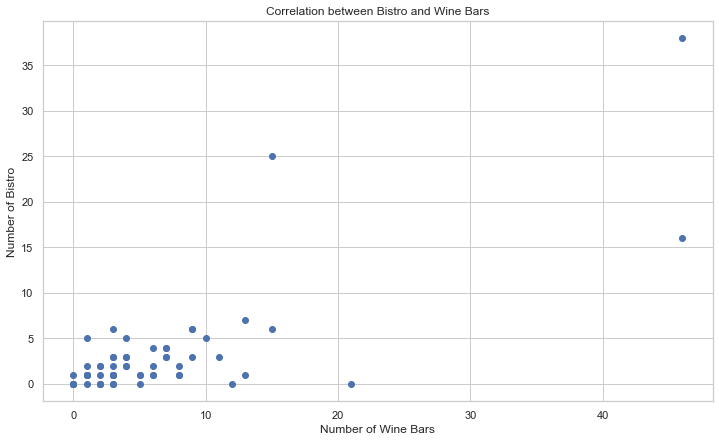

In [186]:
#use to see for each cluster the katanomh ton ratings
#sns.boxplot(x="City", y="Rating", data=final_df)

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(cities_bars_df['wine'], cities_bars_df['bistro'])
ax.set_title('Correlation between Bistro and Wine Bars')
ax.set_xlabel('Number of Wine Bars')
ax.set_ylabel('Number of Bistro')
plt.show()

##### Find Pearson correlation for # of Wine bars and Bistro

In [825]:
from scipy.stats import pearsonr

#pearson_coef, p_value=pearsonr(final_df['avg_winebar_price'],final_df['avg_winebar_rating'])

pearson_coef, p_value=pearsonr(cities_bars_df['wine'],cities_bars_df['bistro'])

print(pearson_coef)
print(p_value)

0.7709239068926617
5.80417973210664e-13


##### Check the outliers

In [187]:
cities_bars_df[cities_bars_df['bistro']>15].head()

,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
0,Athinai,762100,37.980,23.730,46,38,2.000000,132.413043,7.695652
1,Thessaloniki,372100,40.640,22.940,46,16,1.869565,41.500000,7.602174
26,Viron,62500,37.970,23.750,15,25,1.866667,25.200000,7.213333


#### Explore the correlation between Price and Rating

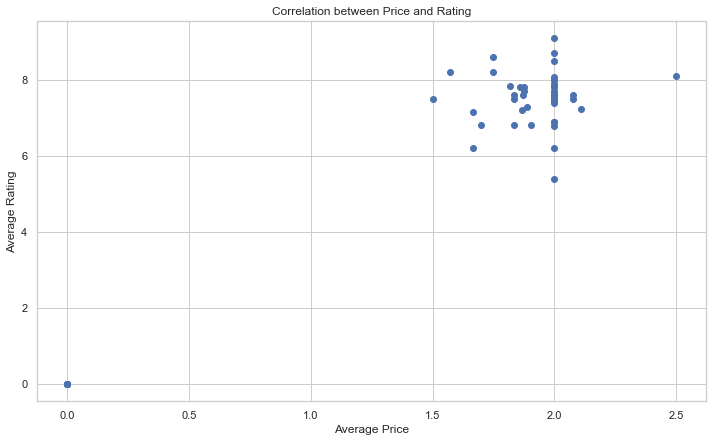

In [339]:
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(cities_bars_df['avg_winebar_price'], cities_bars_df['avg_winebar_rating'])
ax.set_title('Correlation between Price and Rating')
ax.set_xlabel('Average Price')
ax.set_ylabel('Average Rating')
plt.show()

### Prepare Data for Clustering

In [434]:
#Create avg number of venues (wine bar and bistro) per person for each city
cluster_prep_df=pysqldf("select city, cast(population as int) population, cast(wine as float) /population wine_var,cast(bistro as float) /population bistro_var,  \
    avg_winebar_price,avg_winebar_likes,avg_winebar_rating from cities_bars_df ")
cluster_prep_df.shape

(60, 7)

In [407]:
cluster_prep_df.head()

,City,population,wine_var,bistro_var,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
0,Athinai,762100,0.000060,0.000050,2.000000,132.413043,7.695652
1,Thessaloniki,372100,0.000124,0.000043,1.869565,41.500000,7.602174
2,Piraieus,179600,0.000022,0.000011,2.000000,26.500000,9.100000
3,Patrai,164000,0.000079,0.000043,2.076923,26.384615,7.500000
4,Peristerion,141000,0.000014,0.000014,2.000000,5.500000,7.800000


#### Normalize data

In [435]:
from sklearn.preprocessing import MinMaxScaler

cluster_prep_df.drop('City', 1,inplace=True)

mms = MinMaxScaler( )
mms.fit(cluster_prep_df)

cluster_prep_df=pd.DataFrame(mms.transform(cluster_prep_df))

In [436]:
cluster_prep_df.head()

,0,1,2,3,4,5
0,1.000000,0.103473,0.124656,0.800000,0.903843,0.845676
1,0.466192,0.211925,0.107498,0.747826,0.283276,0.835404
2,0.202710,0.038180,0.027840,0.800000,0.180887,1.000000
3,0.181358,0.135889,0.106707,0.830769,0.180100,0.824176
4,0.149877,0.024316,0.035461,0.800000,0.037543,0.857143


### Find the optimal K for K-Means using the elbow method

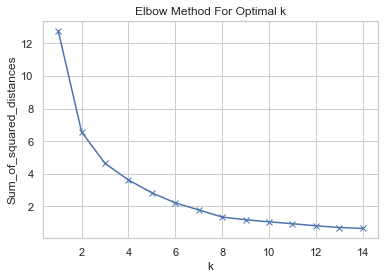

In [426]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_prep_df)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Execute the K-Means clustering algorithm

In [638]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(cluster_prep_df)

In [639]:
#Create final dataframe based on the initial dataframe with the City, locations and all variables used
final_df = cities_bars_df.copy()

#Add the clusters to final dataframe to use it for presentation and evaluation
final_df.insert(0, 'Cluster', kmeans.labels_)

final_df.head()

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
0,6,Athinai,762100,37.980,23.730,46,38,2.000000,132.413043,7.695652
1,4,Thessaloniki,372100,40.640,22.940,46,16,1.869565,41.500000,7.602174
2,4,Piraieus,179600,37.960,23.640,4,2,2.000000,26.500000,9.100000
3,4,Patrai,164000,38.240,21.730,13,7,2.076923,26.384615,7.500000
4,0,Peristerion,141000,38.020,23.700,2,2,2.000000,5.500000,7.800000


In [640]:
# create map
map_clusters =folium.Map(location=[38.2749497, 23.8102717], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_df['Latitude'], final_df['Longitude'], final_df['City'], final_df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Evaluate clustering results

#### Check each cluster averages compared to total averages

Calculate total average for all metrics
<p> Number of wine bars and number of Bistro were transformed to Number of venues per 100000 persons for easier interpretation

In [641]:
final_descr_df=pysqldf("select avg(population) total_avg_population,avg((cast(wine as float) /population)*100000)  total_avg_winebar,avg((cast(bistro as float) /population)*100000) total_avg_bistro,\
avg(avg_winebar_price) total_avg_price,avg(avg_winebar_likes) total_avg_likes,avg(avg_winebar_rating) total_avg_rating from final_df where wine<>0")
#final_descr_df=pd.DataFrame(final_descr_df[final_descr_df['wine_var']!=0].mean())

final_descr_df.head()

,total_avg_population,total_avg_winebar,total_avg_bistro,total_avg_price,total_avg_likes,total_avg_rating
0,85032.727273,9.513037,4.374287,1.942271,24.50172,7.52587


Calculate metric averages per cluster

In [642]:
pysqldf("select  Cluster,count(*) cities,avg(population) avg_population,avg(wine_var)*100000 avg_winebar,avg(bistro_var)*100000 avg_bistro,avg(avg_winebar_price),avg(avg_winebar_likes),avg(avg_winebar_rating), \
total_avg_population,total_avg_winebar,total_avg_bistro,total_avg_price,total_avg_likes,total_avg_rating,0.25 as threashold \
from (select * ,  cast(wine as float) /population wine_var,cast(bistro as float) /population bistro_var from final_df) tmp cross join final_descr_df group by [Cluster]")


,Cluster,cities,avg_population,avg_winebar,avg_bistro,avg(avg_winebar_price),avg(avg_winebar_likes),avg(avg_winebar_rating),total_avg_population,total_avg_winebar,total_avg_bistro,total_avg_price,total_avg_likes,total_avg_rating,threashold
0,0,28,62921.428571,5.446856,2.548391,1.939838,8.307653,7.453784,85032.727273,9.513037,4.374287,1.942271,24.50172,7.52587,0.25
1,1,5,52020.000000,0.000000,0.289855,0.000000,0.000000,0.000000,85032.727273,9.513037,4.374287,1.942271,24.50172,7.52587,0.25
2,2,3,59366.666667,8.399810,5.093948,2.023810,112.103175,8.127778,85032.727273,9.513037,4.374287,1.942271,24.50172,7.52587,0.25
3,3,1,62500.000000,24.000000,40.000000,1.866667,25.200000,7.213333,85032.727273,9.513037,4.374287,1.942271,24.50172,7.52587,0.25
4,4,13,114892.307692,8.951285,2.855173,1.941875,40.294551,7.795584,85032.727273,9.513037,4.374287,1.942271,24.50172,7.52587,0.25
5,5,1,36000.000000,58.333333,0.000000,1.904762,5.523810,6.804762,85032.727273,9.513037,4.374287,1.942271,24.50172,7.52587,0.25
6,6,1,762100.000000,6.035953,4.986222,2.000000,132.413043,7.695652,85032.727273,9.513037,4.374287,1.942271,24.50172,7.52587,0.25
7,7,8,47837.500000,17.596208,8.980689,1.927778,11.463095,7.222153,85032.727273,9.513037,4.374287,1.942271,24.50172,7.52587,0.25


#### Create a Heatmap for easier clusters evaluation

##### Heatmap rules:
In the y-axis of the Heatmap we see the cluster number and x-axis has the six different variables In order for the evaluation to be easier, we will use three main values to depict the results of the comparison between cluster average metrics and total averages:
<li>Low: blue color, indicating that the average variable value of the cluster is below a certain threshold of the total average
<li>Avg: grey color, indicating that the average variable value of the cluster is around the total average
<li>High:  red color, indicating that the average variable value of the cluster is above a certain threshold of the total average

<p>Different threshold were used depending the variable used for the comparison, because of the different scale and distribution of each variable (i.e population vs rating ):

<li>very_small_threshold=2% diff from the total average, used for price comparison
<li>small_threshold=3% diff from the total average, used for rating comparison
<li>medium_threshold=20%  diff from the total average, used for number of wine bars and bistro comparison 
<li>big_threshold=50% diff from the total average, used for population and likes comparison


Text(0.5, 1.0, 'Clustering Heatmap')

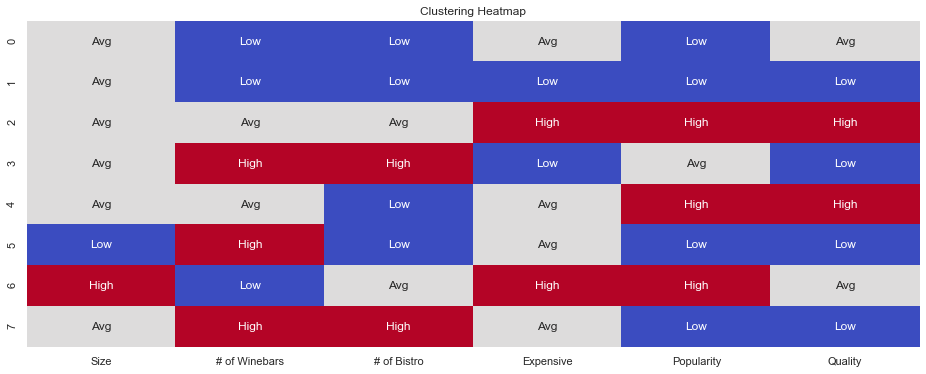

In [664]:
#Gather everything per Cluster and cross join with the total averages
cluster_eval_df=pysqldf("select  Cluster,count(*) cities,avg(population) avg_population,avg(wine_var)*100000 avg_winebar,avg(bistro_var)*100000 avg_bistro,avg(avg_winebar_price) avg_price,\
avg(avg_winebar_likes) avg_likes,avg(avg_winebar_rating) avg_rating, total_avg_population,total_avg_winebar,total_avg_bistro,total_avg_price,total_avg_likes,total_avg_rating,\
0.02 as very_small_threshold,0.03 as small_threshold,0.2 as medium_threshold,0.5 as big_threshold \
from (select * ,  cast(wine as float) /population wine_var,cast(bistro as float) /population bistro_var from final_df) tmp cross join final_descr_df group by [Cluster]")

#Make the comparisons of each cluster's variable values vs total averages. Based on each variable threshold calculate on the the values -1=Low, 0=Average, 1=High
cluster_eval_df=pysqldf("select  \
case when ((avg_population-total_avg_population)/ total_avg_population) >big_threshold then 1  when   ((avg_population-total_avg_population)/ total_avg_population)<-big_threshold then -1 else 0 end as Size,\
case when ((avg_winebar-total_avg_winebar)/ total_avg_winebar) >medium_threshold then 1  when   ((avg_winebar-total_avg_winebar)/ total_avg_winebar)<-medium_threshold then -1 else 0 end as [# of Winebars], \
case when ((avg_bistro-total_avg_bistro)/ total_avg_bistro) >medium_threshold then 1  when   ((avg_bistro-total_avg_bistro)/ total_avg_bistro)<-medium_threshold then -1 else 0 end as  [# of Bistro],  \
case when ((avg_price-total_avg_price)/ total_avg_price) >very_small_threshold then 1  when   ((avg_price-total_avg_price)/ total_avg_price)<-very_small_threshold then -1 else 0 end as [Expensive],  \
case when ((avg_likes-total_avg_likes)/ total_avg_likes) >big_threshold then 1  when   ((avg_likes-total_avg_likes)/ total_avg_likes)<-big_threshold then -1 else 0 end as Popularity,  \
case when ((avg_rating-total_avg_rating)/ total_avg_rating) >small_threshold then 1  when   ((avg_rating-total_avg_rating)/ total_avg_rating)<-small_threshold then -1 else 0 end as Quality  \
from cluster_eval_df")

#create label in order to translate -1,0,1 to Low,Avg,High in Heatmap
cluster_eval_lbl_df=cluster_eval_df.copy()
cluster_eval_lbl_df.replace(1,'High',inplace=True)
cluster_eval_lbl_df.replace(-1,'Low',inplace=True)
cluster_eval_lbl_df.replace(0,'Avg',inplace=True)

#Plot the Heatmap
labels =  np.array(cluster_eval_lbl_df)    
plt.figure(figsize=(16, 6))
sns.heatmap(cluster_eval_df, vmin=-1,vmax=1, annot=labels, cmap=sns.color_palette("coolwarm", as_cmap=True), fmt='', cbar=False).set_title('Clustering Heatmap')       

## Clustering Results

### Analyze each Cluster

#### Cluster 0 Details
##### Small number of wine bars, average quality and price, low popularity
Comment	The biggest cluster consists of cities with no strong points. We can assume that this is the average having at the same time less number of wine bars per person than the average, that at the same time are not so popular. To be more precise the average Likes of cluster’s wine bars are the second worst from the seven clusters that have wine bars. The characteristics of this cluster don’t show an opportunity or something special. It’s an average after all. 

In [789]:
final_df.loc[final_df['Cluster'] == 0]

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
4,0,Peristerion,141000,38.020,23.700,2,2,2.000000,5.500000,7.800000
7,0,Kallithea,112100,37.950,23.700,6,2,2.000000,13.333333,7.500000
9,0,Kalamaria,89200,40.580,22.950,7,3,1.857143,15.714286,7.814286
11,0,Ilion,82700,38.030,23.710,1,0,2.000000,7.000000,7.500000
14,0,Zografos,77800,37.980,23.770,4,5,1.750000,19.250000,8.200000
15,0,Ilioupoli,77600,37.930,23.760,2,0,2.000000,11.500000,8.500000
16,0,Akharnai,77000,38.080,23.730,2,0,2.000000,5.000000,7.500000
17,0,Aigaleo,75700,37.980,23.680,1,1,2.000000,7.000000,7.500000
20,0,Amarousion,71000,38.050,23.800,3,3,2.000000,5.000000,7.500000
22,0,Nea ionia,67500,38.030,23.750,1,1,2.000000,3.000000,7.500000


#### Cluster 1 Details
##### No wine Bars
This is an expected cluster with cities that don’t have any wine bars. This fact can be probably explained form the fact that all 5 cities are part of metropolitan areas, so there maybe another center next to them where restaurant and bars exists and social life is more developed. There is no reason to invest in such an area.

In [655]:
final_df.loc[final_df['Cluster'] == 1]

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
13,1,Keratsinion,77800,37.960,23.620,0,0,0.0,0.0,0.0
21,1,Koridallos,69000,37.990,23.650,0,1,0.0,0.0,0.0
50,1,Stauroupolis,42600,40.670,22.930,0,0,0.0,0.0,0.0
53,1,Polikhni,37000,40.660,22.950,0,0,0.0,0.0,0.0
56,1,Ayioi anaryiroi,33700,38.020,23.720,0,0,0.0,0.0,0.0


#### Cluster 2 Details
##### Consists of cities with an average number of wine bars and exceptional quality
These 3 cities are top in terms of Wine bars quality and Popularity. It is a bit risky to invest in such an area where people are happy with the existing wine bars.

In [656]:
final_df.loc[final_df['Cluster'] == 2] 

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
19,2,Khalandrion,73300,38.030,23.800,7,4,1.571429,110.142857,8.200000
31,2,Khalkis,54800,38.460,23.600,2,1,2.500000,146.500000,8.100000
37,2,Alexandroupoli,50000,40.850,25.870,6,4,2.000000,79.666667,8.083333


#### Cluster 3 Details
##### Many wine bars and bistro with below average quality
This one city cluster is the only one that has at the same time a high number of wine bars and bistro but the number of bistro (40 per 100k persons) is greater (almost double) than the number of wine bars (24 per 100k persons). It is worth mention that the Quality of the existing wine bars are below average. This city needs more analysis and it is a good candidate to host one more wine bar.

In [647]:
final_df.loc[final_df['Cluster'] == 3] 

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
26,3,Viron,62500,37.970,23.750,15,25,1.866667,25.2,7.213333


#### Cluster 4 Details
##### Small number of wine bars, average price, high in quality and popularity 
The second biggest cluster with 13 cities consists of cities with nothing special in terms of number of wine bars but it performs high in terms of quality and popularity. We could say that this is the alter ego of cluster 0 having similar characteristics but the exact opposite behavior regarding popularity and quality. In addition it is similar to “High Performance” cluster 2 both having an average number of wine bars and high popularity and quality. Their difference is that cluster 2 is much better in popularity with an average of 112 likes vs 40 likes and an average rating of 8.13 vs 7.79. The same comment as in cluster 2 is valid here. Too risky to invest to a high performance city with already popular places with good quality.

In [791]:
final_df.loc[final_df['Cluster'] == 4]

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
1,4,Thessaloniki,372100,40.640,22.940,46,16,1.869565,41.500000,7.602174
2,4,Piraieus,179600,37.960,23.640,4,2,2.000000,26.500000,9.100000
3,4,Patrai,164000,38.240,21.730,13,7,2.076923,26.384615,7.500000
5,4,Iraklion_Crete,133800,35.330,25.130,9,6,2.111111,55.111111,7.233333
6,4,Larisa,127200,39.640,22.420,13,1,2.076923,31.692308,7.592308
8,4,Nikaia,95200,37.970,23.650,5,1,2.000000,26.600000,7.900000
10,4,Volos,84300,39.370,22.950,7,3,2.000000,33.571429,7.600000
12,4,Glifada,82200,37.870,23.750,8,2,1.875000,38.875000,7.812500
18,4,Nea smirni,75600,37.950,23.720,11,3,1.818182,29.636364,7.827273
36,4,Kalamata,50300,37.040,22.110,8,1,2.000000,54.875000,7.575000


#### Cluster 5 Details
##### Many wine bars but low quality and likes 
One of a kind city and the only one that compose this cluster. Kozani is a small city having an impressive number of wine bars compared to the population with 58 wine bars per 100k persons. On the other hand is very poor when it comes to popularity and quality. This fact makes Kozani a city worth thinking it as the city of your investment. 

In [659]:
final_df.loc[final_df['Cluster'] == 5] 

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
54,5,Kozani,36000,40.300,21.790,21,0,1.904762,5.52381,6.804762


#### Cluster 6 Details
##### The biggest in size, not so many wine bars with average quality, popular places  and high prices
The Greek capital is the only city of cluster 6. This is normal as its characteristics are unique. The major difference here is the size (762000 population) that is double than the second biggest city in Greece (Thessaloniki - 372100). At the same time it is an expensive city with wine bars of average quality. With the results we have in our hands now, it is not so attractive to invest there. In order to check the possibility of opening a new wine bar in Athens a different analysis should take place on each neighborhoods or hot areas of the city. 

In [660]:
final_df.loc[final_df['Cluster'] == 6] # big city mia kathgoria monh ths #sikaie - kozani :Wine Bar Champions , with good prices and ligo kato apo meso oro

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
0,6,Athinai,762100,37.980,23.730,46,38,2.0,132.413043,7.695652


#### Cluster 7 Details
##### Many wine bars with below the average popularity and quality
The third cluster in size (8 cities) that compares to cluster 0 “The Not so Popular Average” and cluster 4 “The Popular Average”, is a cluster with high number of wine bars and bistros, almost the double of the average. This is exactly the difference with cluster 0 and the low popularity and quality is its difference with cluster 4. The fact that the wine bars of the cities of this cluster are not so popular and of low quality makes this cluster interesting to examine one by one the 8 cities in order to identify potential business opportunity.

In [661]:
final_df.loc[final_df['Cluster'] == 7] # pano se winebar kai bistro per person kato se rating kai likes, price sto meso oro # antitheto tou clust 0 # Big difference between winebar and bistro. Bistro Champions. Nice Price, below average in quality

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating
25,7,Ioannina,63000,39.670,20.850,10,5,1.700000,14.700000,6.810000
27,7,Kavala,60000,40.940,24.400,9,3,1.888889,6.444444,7.300000
32,7,Khania,54600,35.510,24.020,15,6,2.000000,13.600000,7.986667
34,7,Rodos,53500,36.440,28.220,9,6,2.000000,4.888889,6.788889
48,7,Agrinion,43300,38.620,21.410,7,4,2.000000,8.571429,6.900000
49,7,Sikeai,42700,40.650,22.950,12,0,1.833333,22.583333,7.591667
57,7,Kholargos,32900,38.000,23.800,4,3,2.000000,17.250000,6.900000
58,7,Karditsa,32700,39.370,21.920,3,6,2.000000,3.666667,7.500000


#### Take an overview of all cities sorted by Rating

In [793]:
pysqldf("select city,avg(population) population, avg(avg_winebar_price) price,avg(avg_winebar_likes) likes,avg(avg_winebar_rating) rating, \
avg((cast(wine as float) /population)*100000)  winebar,avg((cast(bistro as float) /population)*100000) bistro from final_df where wine<>0 group by city order by rating")

,City,population,price,likes,rating,winebar,bistro
0,Trikala,49800.0,2.000000,3.666667,5.400000,6.024096,2.008032
1,Galatsion,59300.0,1.666667,9.000000,6.200000,5.059022,0.000000
2,Kifisia,44900.0,2.000000,10.666667,6.200000,6.681514,4.454343
3,Rodos,53500.0,2.000000,4.888889,6.788889,16.822430,11.214953
4,Kozani,36000.0,1.904762,5.523810,6.804762,58.333333,0.000000
5,Ioannina,63000.0,1.700000,14.700000,6.810000,15.873016,7.936508
6,Palaion faliron,66200.0,1.833333,15.833333,6.816667,9.063444,1.510574
7,Agrinion,43300.0,2.000000,8.571429,6.900000,16.166282,9.237875
8,Kholargos,32900.0,2.000000,17.250000,6.900000,12.158055,9.118541
9,Kalamakion,38900.0,1.666667,61.000000,7.166667,7.712082,2.570694


### Going into detail to selected Clusters

#### Cluster 3

##### Show Winebars of Cluster 3 on map
Create marks for the map. Size based on Rating and Color based on Likes

In [725]:
viron_map_df=pysqldf("select t1.* from cities_winebars_df t1 where city='Viron'")

viron_map_df['venue_size'] = pd.qcut(viron_map_df['Rating'].rank(method='first'), 2,labels= [3, 9])

viron_map_df['venue_color'] =  pd.qcut(viron_map_df['Likes'].rank(method='first'), 2, labels=['blue', 'red'])

viron_map_df.head(50).sort_values(['venue_color'])

,City,Population,City_Latitude,City_Longitude,Venue_Id,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Distance,Venue_Category,Price,Likes,Rating,avg_price_city,avg_rating_city,avg_likes_city,venue_size,venue_color
0,Viron,62500,37.970,23.750,4d92019af5388cfa4a20c23d,Frynis cafe,37.966023,23.748564,460,Wine Bar,2.0,7.0,7.2,1.846154,7.25,31.818182,3,blue
1,Viron,62500,37.970,23.750,4ebef98d7ee54e4cd253a9f6,Baez,37.978394,23.739358,1321,Café,1.0,2.0,7.2,1.846154,7.25,31.818182,3,blue
2,Viron,62500,37.970,23.750,504110fee4b0741ad1147924,Ανω Πουρναρουσα,37.967483,23.744749,539,Wine Bar,2.0,2.0,7.2,1.846154,7.25,31.818182,3,blue
5,Viron,62500,37.970,23.750,5267f82111d24d4fd8b976d0,marinas wine bar,37.972118,23.743125,647,Wine Bar,2.0,2.0,7.2,1.846154,7.25,31.818182,3,blue
9,Viron,62500,37.970,23.750,5650efcb498ec8a799911971,Ελλ' οίνον,37.968755,23.755116,469,Meze Restaurant,2.0,1.0,7.2,1.846154,7.25,31.818182,9,blue
11,Viron,62500,37.970,23.750,5a226ca9916bc17361cc2df5,All About Wine,37.977668,23.738849,1298,Wine Shop,2.0,2.0,7.2,1.846154,7.25,31.818182,9,blue
12,Viron,62500,37.970,23.750,5acb65c8c824ae0eaf718b6f,49,37.979819,23.747097,1122,Wine Bar,2.0,4.0,7.2,1.846154,7.25,31.818182,9,blue
14,Viron,62500,37.970,23.750,5ed193e918038900082142d5,Phoenix Bar,37.968459,23.743894,562,Wine Bar,2.0,1.0,7.2,1.846154,7.25,31.818182,9,blue
3,Viron,62500,37.970,23.750,50620050e4b08374aab9de9d,El Vino,37.980278,23.738095,1549,Wine Bar,2.0,7.0,7.2,1.846154,7.25,31.818182,3,red
4,Viron,62500,37.970,23.750,514388d0e4b01d5366646d2a,Stinking Bishop,37.978461,23.743299,1110,Gastropub,2.0,271.0,8.3,1.846154,7.25,31.818182,9,red


In [792]:

# create map
map_cities =folium.Map(location=[37.97035625407832, 23.74967435656659],height='100%', zoom_start=15,tiles='CartoDB Positron')


# add markers to the map
for lat, lon, poi,m_color,sz,pop,like in zip(viron_map_df['Venue_Latitude'], viron_map_df['Venue_Longitude'], viron_map_df['Venue_Name'],\
                                        viron_map_df['venue_color'],viron_map_df['venue_size'],viron_map_df['Rating'],viron_map_df['Likes']):
    label = folium.Popup(str(poi), parse_html=True)
    label = folium.Popup(str(poi) + ' Rating ' + str(pop) + ' Likes ' + str(like), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=[sz],
        popup=label,
        fill=True,
        fill_opacity=0.8, color=[m_color]).add_to(map_cities)
 

map_cities

#### Cluster 5

##### Show Rating distribution for cluster 5

<AxesSubplot:title={'center':'Kozani Wine Bars Rating Distribution'}>

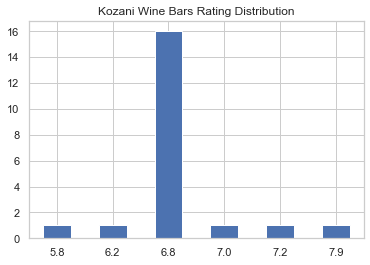

In [758]:
#Rating distribution
cities_winebars_df[cities_winebars_df['City']=='Kozani'].Rating.value_counts().sort_index().plot.bar( x='Rating', rot=0, title='Kozani Wine Bars Rating Distribution')

##### Show Winebars of Cluster 5 on map
Create marks for the map. Size based on Rating and Color based on Likes

In [759]:

kozani_map_df=pysqldf("select t1.* from cities_winebars_df t1 where city='Kozani'")

kozani_map_df['venue_size'] = pd.qcut(kozani_map_df['Rating'].rank(method='first'), 2,labels= [3, 9])

kozani_map_df['venue_color'] =  pd.qcut(kozani_map_df['Likes'].rank(method='first'), 2, labels=['blue', 'red'])

kozani_map_df.head(50).sort_values(['venue_color'])

,City,Population,City_Latitude,City_Longitude,Venue_Id,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Distance,Venue_Category,Price,Likes,Rating,avg_price_city,avg_rating_city,avg_likes_city,venue_size,venue_color
0,Kozani,36000,40.300,21.790,4e137faa1838843250ff0f0d,Έθος,40.302354,21.787378,343,Wine Bar,2.0,1.0,6.8,1.904762,6.82,4.933333,3,blue
17,Kozani,36000,40.300,21.790,58728bd8375c4a6a9ce875c2,50-50,40.296078,21.784895,615,Wine Bar,2.0,2.0,6.8,1.904762,6.82,4.933333,9,blue
14,Kozani,36000,40.300,21.790,5468d96f498ede6c362fb289,ρακοζαλάδες,40.302284,21.787338,340,Wine Bar,2.0,1.0,6.8,1.904762,6.82,4.933333,9,blue
19,Kozani,36000,40.300,21.790,594d21b210345b445d5e3ff7,Βόλτα Memories,40.301182,21.786970,288,Café,1.0,4.0,6.8,1.904762,6.82,4.933333,9,blue
9,Kozani,36000,40.300,21.790,538648c6498e6c5efec02c57,Μη σε μέλι,40.297371,21.784031,585,Wine Bar,2.0,1.0,6.8,1.904762,6.82,4.933333,3,blue
7,Kozani,36000,40.300,21.790,52bc9ca6498ee3f868d25b43,Όπως Παλιά,40.300989,21.787297,254,Wine Bar,2.0,2.0,6.8,1.904762,6.82,4.933333,3,blue
10,Kozani,36000,40.300,21.790,53c59f86498e8f973827a4e1,the hook,40.297946,21.789288,236,Wine Bar,2.0,1.0,6.8,1.904762,6.82,4.933333,9,blue
5,Kozani,36000,40.300,21.790,514f80c9e4b04b411b65a08b,Πέρι Οίνου και Άλλων,40.300671,21.786566,300,Wine Bar,2.0,1.0,6.8,1.904762,6.82,4.933333,3,blue
2,Kozani,36000,40.300,21.790,4f8de2b3e4b047e9edd8bd16,Σοκάκι,40.296802,21.787489,414,Wine Bar,2.0,1.0,6.8,1.904762,6.82,4.933333,3,blue
1,Kozani,36000,40.300,21.790,4f6fb87ce4b0f577d404b599,Vespa Cafe-bar,40.302123,21.787304,328,Wine Bar,2.0,7.0,6.8,1.904762,6.82,4.933333,3,blue


In [794]:
# create map
map_cities =folium.Map(location=[40.299665521652464, 21.79215726811881],height='100%', zoom_start=15,tiles='CartoDB Positron')


# add markers to the map
for lat, lon, poi,m_color,sz,pop,like in zip(kozani_map_df['Venue_Latitude'], kozani_map_df['Venue_Longitude'], kozani_map_df['Venue_Name'],\
                                        kozani_map_df['venue_color'],kozani_map_df['venue_size'],kozani_map_df['Rating'],kozani_map_df['Likes']):
    label = folium.Popup(str(poi), parse_html=True)
    label = folium.Popup(str(poi) + ' Rating ' + str(pop) + ' Likes ' + str(like), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=[sz],
        popup=label,
        fill=True,
        fill_opacity=0.8, color=[m_color]).add_to(map_cities)
 

map_cities

#### Cluster 7

##### Show Cities of Cluster 7 on map
Create marks for the map. Size based on Rating and Color based on Likes

In [765]:
cluster7_map_df=pysqldf("select t1.* from final_df t1 where cluster=7")

cluster7_map_df['city_size'] = pd.qcut(cluster7_map_df['avg_winebar_rating'].rank(method='first'), 2,labels= [3, 9])

cluster7_map_df['city_color'] =  pd.qcut(cluster7_map_df['avg_winebar_likes'].rank(method='first'), 2, labels=['blue', 'red'])

cluster7_map_df.head(50).sort_values(['city_color'])

,Cluster,City,Population,Latitude,Longitude,wine,bistro,avg_winebar_price,avg_winebar_likes,avg_winebar_rating,city_size,city_color
1,7,Kavala,60000,40.940,24.400,9,3,1.888889,6.444444,7.300000,9,blue
3,7,Rodos,53500,36.440,28.220,9,6,2.000000,4.888889,6.788889,3,blue
4,7,Agrinion,43300,38.620,21.410,7,4,2.000000,8.571429,6.900000,3,blue
7,7,Karditsa,32700,39.370,21.920,3,6,2.000000,3.666667,7.500000,9,blue
0,7,Ioannina,63000,39.670,20.850,10,5,1.700000,14.700000,6.810000,3,red
2,7,Khania,54600,35.510,24.020,15,6,2.000000,13.600000,7.986667,9,red
5,7,Sikeai,42700,40.650,22.950,12,0,1.833333,22.583333,7.591667,9,red
6,7,Kholargos,32900,38.000,23.800,4,3,2.000000,17.250000,6.900000,3,red


In [769]:
# create map
map_cities =folium.Map(location=[38.2749497, 23.8102717],height='100%', zoom_start=7,tiles='CartoDB Positron')


# add markers to the map
for lat, lon, poi,m_color,sz,pop,like in zip(cluster7_map_df['Latitude'], cluster7_map_df['Longitude'], cluster7_map_df['City'],\
                                        cluster7_map_df['city_color'],cluster7_map_df['city_size'],cluster7_map_df['avg_winebar_rating'],cluster7_map_df['avg_winebar_likes']):
    label = folium.Popup(str(poi), parse_html=True)
    label = folium.Popup(str(poi) + ' Rating ' + str(pop) + ' Likes ' + str(like), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=[sz],
        popup=label,
        fill=True,
        fill_opacity=0.8, color=[m_color]).add_to(map_cities)
 

map_cities

##### Rhodes

##### Show Winebars for city Rhodes of Cluster 7 on map
Create marks for the map. Size based on Rating and Color based on Likes

In [775]:
rhodes_map_df=pysqldf("select t1.* from cities_winebars_df t1 where city='Rodos'")

rhodes_map_df['venue_size'] = pd.qcut(rhodes_map_df['Rating'].rank(method='first'), 2,labels= [3, 9])

rhodes_map_df['venue_color'] =  pd.qcut(rhodes_map_df['Likes'].rank(method='first'), 2, labels=['blue', 'red'])

rhodes_map_df.head(50).sort_values(['venue_color'])

,City,Population,City_Latitude,City_Longitude,Venue_Id,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Distance,Venue_Category,Price,Likes,Rating,avg_price_city,avg_rating_city,avg_likes_city,venue_size,venue_color
0,Rodos,53500,36.440,28.220,4d570d70d8f7a090affce30a,Paffuto,36.443232,28.228015,802,Wine Bar,2.0,7.0,7.0,2.0,6.75,3.833333,9,blue
3,Rodos,53500,36.440,28.220,51c4d56e498e13f89116d380,Διπορτο,36.450374,28.220393,1155,Wine Bar,2.0,1.0,6.8,2.0,6.75,3.833333,3,blue
5,Rodos,53500,36.440,28.220,5bef2cf44acb19002cb32a7f,10Gr,36.444169,28.226839,768,Wine Bar,2.0,5.0,6.8,2.0,6.75,3.833333,3,blue
6,Rodos,53500,36.440,28.220,5ce9b8981af852002cb183fa,L' Éternel French Bar,36.443206,28.227736,779,Wine Bar,2.0,1.0,6.8,2.0,6.75,3.833333,9,blue
8,Rodos,53500,36.440,28.220,5f176e194488043dd35ffb35,Duente By The Glass,36.448586,28.221853,970,Wine Bar,2.0,1.0,6.8,2.0,6.75,3.833333,9,blue
1,Rodos,53500,36.440,28.220,4ee3c28ae5faffd73102b76f,Minibar,36.449578,28.222813,1095,Wine Bar,2.0,8.0,6.5,2.0,6.75,3.833333,3,red
2,Rodos,53500,36.440,28.220,4f91ce56e4b0780fc56a8692,Oiwnos,36.443187,28.227877,789,Wine Bar,2.0,7.0,6.8,2.0,6.75,3.833333,3,red
4,Rodos,53500,36.440,28.220,51d5a896498ee27488003d4e,The Cellar of Knights (Το Κελάρι των Ιπποτών),36.443459,28.228382,843,Wine Bar,2.0,7.0,6.8,2.0,6.75,3.833333,3,red
7,Rodos,53500,36.440,28.220,5cf81f8db9b37b002cc8e67f,wine bar 42,36.451851,28.220889,1321,Wine Bar,2.0,7.0,6.8,2.0,6.75,3.833333,9,red


In [797]:
# create map
map_cities =folium.Map(location=[36.44022386498551, 28.222893080979876],height='100%', zoom_start=15,tiles='CartoDB Positron')


# add markers to the map
for lat, lon, poi,m_color,sz,pop,like in zip(rhodes_map_df['Venue_Latitude'], rhodes_map_df['Venue_Longitude'], rhodes_map_df['Venue_Name'],\
                                        rhodes_map_df['venue_color'],rhodes_map_df['venue_size'],rhodes_map_df['Rating'],rhodes_map_df['Likes']):
    label = folium.Popup(str(poi), parse_html=True)
    label = folium.Popup(str(poi) + ' Rating ' + str(pop) + ' Likes ' + str(like), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=[sz],
        popup=label,
        fill=True,
        fill_opacity=0.8, color=[m_color]).add_to(map_cities)
 

map_cities


## Conclusion

In this notebook we analyzed the wine bar status of the 60 biggest cities in Greece via clustering, resulting proposal on where and why someone could open a new wine bar. We used Greek Population and location info combined with Wine bars data taken from Foursquare API. 6 main variables for each city were extracted in order to be used to our analysis: Population, Number of Wine bars / Person, Number of Bistro / Person, Wine Bar average Price Range, average Number of Likes and Rating average. We explored the data, transform them and prepare them for K-Means Clustering. We executed the clustering algorithm producing 8 clusters and we analyzed each one of them taking into account the numerical data. Finally we proposed 3 clusters on which potential for new business opportunity was identified. What we need to have in mind is that numeric data and analysis are a very strong tool in our hands, but understanding the culture of the people of a city, talk to them,  walk to the streets and feel the vibes and the atmosphere is equally important before making your next business move. 

##### Stay calm and drink wine!


@Copyright Ilias Kapetanakis 2021